<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Foreword" data-toc-modified-id="Foreword-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Foreword</a></span><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Goal</a></span></li><li><span><a href="#Process" data-toc-modified-id="Process-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Process</a></span></li></ul></li><li><span><a href="#Code" data-toc-modified-id="Code-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Code</a></span><ul class="toc-item"><li><span><a href="#imports" data-toc-modified-id="imports-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>imports</a></span></li><li><span><a href="#Credentials" data-toc-modified-id="Credentials-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Credentials</a></span></li><li><span><a href="#Data-fetching" data-toc-modified-id="Data-fetching-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Data fetching</a></span></li><li><span><a href="#Data-analysis" data-toc-modified-id="Data-analysis-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Data analysis</a></span></li><li><span><a href="#API" data-toc-modified-id="API-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>API</a></span></li><li><span><a href="#API-results-to-dataframe" data-toc-modified-id="API-results-to-dataframe-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>API results to dataframe</a></span></li><li><span><a href="#Results-analysis" data-toc-modified-id="Results-analysis-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Results analysis</a></span></li></ul></li></ul></div>

In [48]:
import tqdm 
tqdm.__version__

'4.61.1'

# Foreword

This notebook will be used to test the Azure Text Analysis API, more precisely the Sentiment Analysis part.

You'll need the following modules:

- azure-ai-textanalytics==5.1.0b7
- azure-common==1.1.27
- azure-core==1.16.0
- azureml==0.2.7
- ipython==7.22.0
- jupyter==1.0.0
- matplotlib==3.4.2
- numpy==1.21.1
- pandas==1.2.5
- pep8==1.7.1
- python==3.8.3
- requests==2.25.1
- scikit-learn==0.24.2
- scipy==1.5.4
- seaborn==0.11.1
- texthero==1.1.0
- tqdm==4.61.1


## Goal

In this notebook, I'll send tweets and fetch sentiment analysis results from the Azure Text Analytics API.
NB: The credentials should not be hard-coded. You'll have set an environment variable called "AZURE_ANYLITICS" with your API as the value.


## Process

- Get API credentials
- Fill a dataframe with the tweets form the 1,6M tweets DB
- Analyse the data
- Extract a sample 
- Send sample as batch to Azure API
- Fetch and display sentiment analysis results


# Code

## imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import texthero as hero
from texthero import preprocessing
import re
import time

from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential
from wordcloud import WordCloud
from textblob import Word
from textblob import TextBlob
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import spacy

import gc, os, requests
from IPython.display import Markdown, display
from tqdm import tqdm_notebook as tqdm

import warnings
warnings.filterwarnings('ignore')

In [4]:
def printmd(string, color=None):
    colorstr = "<b>{}</b>".format(string)
    display(Markdown(colorstr))

In [6]:
printmd('Most used words for tweets marked as negative')

<b>Most used words for tweets marked as negative</b>

## Credentials

In [55]:
%%capture
tqdm().pandas()

ENDPOINT = "https://ocr-p7-sentiment-api.cognitiveservices.azure.com/"
if ("AZURE_ANALYTICS" not in os.environ):
    print("La clé d'API n'a pas été detectée dans les variables.n")
else:
    API_KEY = os.environ["AZURE_ANALYTICS"]

## Data fetching

<div style='background:#96d6ee;' class='alert alert-block alert-info'><span style='color: #3c6f9c' >Fetching the csv downloaded on Kaggle, 1.6M tweets</span></div>

In [3]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv', header=None)
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'training.1600000.processed.noemoticon.csv'

<div style='background:#96d6ee;' class='alert alert-block alert-info'><span style='color: #3c6f9c' >We only keep the tweet content to send to Azure API</span></div>

In [76]:
df.drop([1, 2, 3, 4], axis=1, inplace=True)
df.columns=["sentiment", "tweet"]
extract = df.sample(1600, random_state=42)
extract.head()

sentiment                                              tweet
541200          0             @chrishasboobs AHHH I HOPE YOUR OK!!! 
750             0  @misstoriblack cool , i have no tweet apps  fo...
766711          0  @TiannaChaos i know  just family drama. its la...
285055          0  School email won't open  and I have geography ...
705995          0                             upper airways problem

## Data analysis

In [2]:
df['word_count'] = df['tweet'].apply(lambda x: len(x.split()))
df['mean_words'] = df['tweet'].apply(
    lambda x: round(sum(len(word) for word in x.split()) / len(x.split()), 2)
)

df['char_count'] = df['tweet'].apply(lambda x: len(x))

NameError: name 'df' is not defined

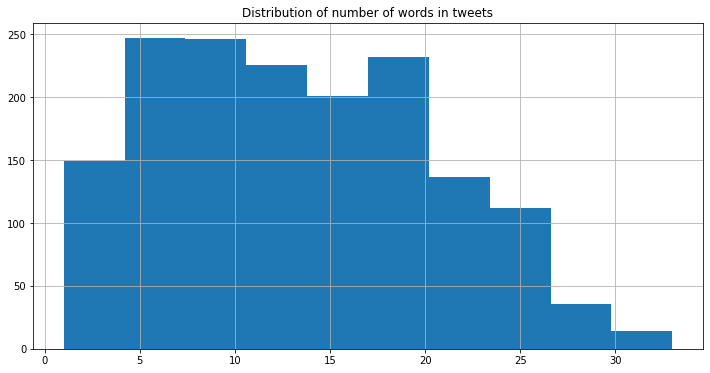

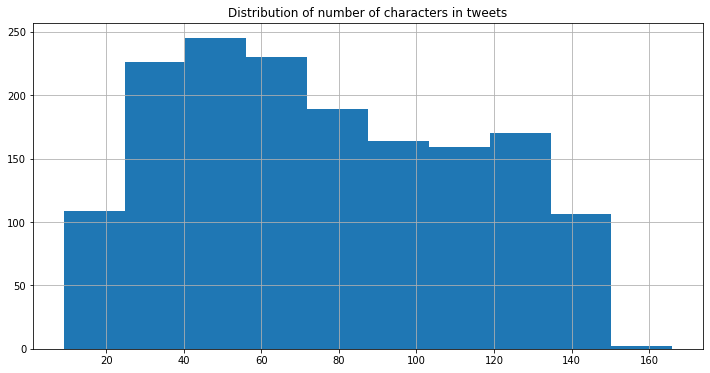

In [71]:
df['word_count'].hist(figsize=(12, 6));
plt.title("Distribution of number of words in tweets")
pass;

plt.figure()
df['char_count'].hist(figsize=(12, 6));
plt.title("Distribution of number of characters in tweets")
pass;

## API

<div style='background:#96d6ee;' class='alert alert-block alert-info'><span style='color: #3c6f9c' >We'll use the TextAnalyticsClient module to send tweets and fetch results.</span></div>

In [72]:
def authenticate_client():
    ta_credential = AzureKeyCredential(API_KEY)
    text_analytics_client = TextAnalyticsClient(
            endpoint=ENDPOINT, 
            credential=ta_credential)
    return text_analytics_client

client = authenticate_client()

<div style='background:#96d6ee;' class='alert alert-block alert-info'><span style='color: #3c6f9c' >Azure API only allow batches of 10, and limits to 1k requests every minute.</span></div>

In [78]:
def sentiment_analysis_example(client, docs=''):
    pos_scores = []
    neu_scores = []
    neg_scores = []
    with tqdm(total=len(docs)) as pbar:
        for i in range(0, len(docs), 10): #only batch of 10 allowed
            if i > 0 and i%1000 == 0: #paid plan: 1000 req / min
                print ("Sleeping between each batch of 1000")
                time.sleep(60)

            documents = docs[i : i+10].to_list()
            response = client.analyze_sentiment(documents=documents)
            result = [doc for doc in response if not doc.is_error]

            for idx, doc in enumerate(result):
                pos_scores.append(doc.confidence_scores.positive)
                neu_scores.append(doc.confidence_scores.neutral)
                neg_scores.append(doc.confidence_scores.negative)
            pbar.update(10)
    display(len(pos_scores))
    extract['positive'] = pos_scores
    extract['neutral'] = neu_scores
    extract['negative'] = neg_scores
    
sentiment_analysis_example(client, extract.tweet)

['@chrishasboobs AHHH I HOPE YOUR OK!!! ', '@misstoriblack cool , i have no tweet apps  for my razr 2', '@TiannaChaos i know  just family drama. its lame.hey next time u hang out with kim n u guys like have a sleepover or whatever, ill call u', "School email won't open  and I have geography stuff on there to revise! *Stupid School* :'(", 'upper airways problem ', "Going to miss Pastor's sermon on Faith... ", 'on lunch....dj should come eat with me ', '@piginthepoke oh why are you feeling like that? ', 'gahh noo!peyton needs to live!this is horrible ', '@mrstessyman thank you glad you like it! There is a product review bit on the site  Enjoy knitting it!']


  0%|          | 0/1600 [00:00<?, ?it/s]

Sleeping between each batch of 1000


1600

## API results to dataframe

In [79]:
def predominant_sentiment(row):
    if row['positive'] > row['neutral'] and row['positive'] > row['negative']:
        return 'positive'
    if row['neutral'] > row['positive'] and row['neutral'] > row['negative']:
        return 'neutral'
    if row['negative'] > row['neutral'] and row['negative'] > row['positive']:
        return 'negative'
extract['predominant'] = extract.apply (lambda row: predominant_sentiment(row), axis=1)
extract.head()

sentiment                                              tweet  \
541200          0             @chrishasboobs AHHH I HOPE YOUR OK!!!    
750             0  @misstoriblack cool , i have no tweet apps  fo...   
766711          0  @TiannaChaos i know  just family drama. its la...   
285055          0  School email won't open  and I have geography ...   
705995          0                             upper airways problem    

        positive  neutral  negative predominant  
541200      1.00     0.00      0.00    positive  
750         0.74     0.19      0.07    positive  
766711      0.02     0.00      0.98    negative  
285055      0.01     0.18      0.81    negative  
705995      0.00     0.00      1.00    negative

## Results analysis

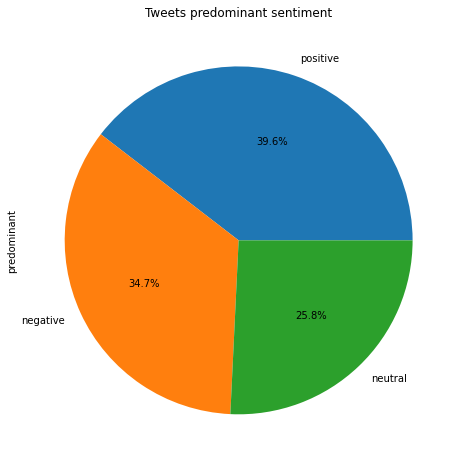

In [136]:
extract['predominant'].value_counts().plot.pie(
    legend=False,
    autopct='%1.1f%%',
    figsize=(8, 8),
    title="Tweets predominant sentiment")
pass

<b>Most used words for reviews marked as positive</b>

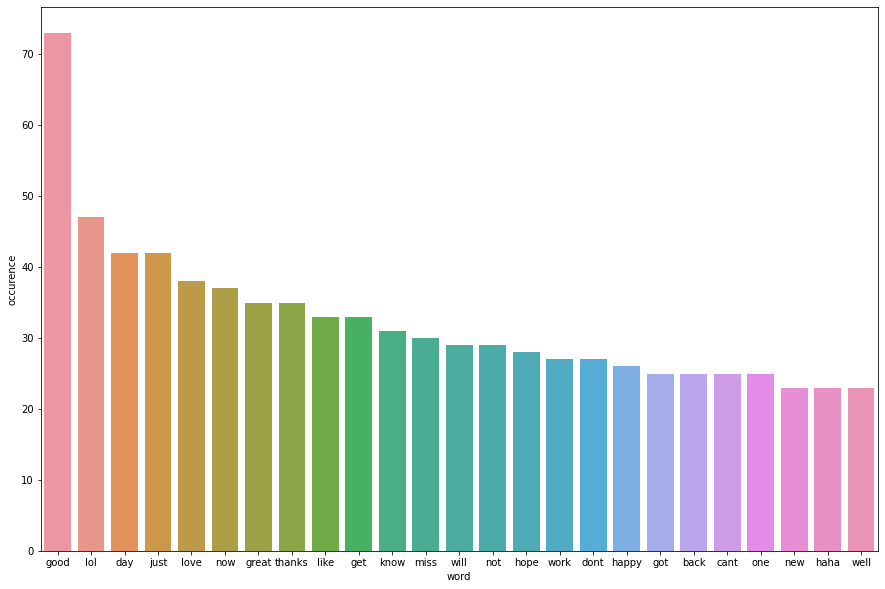

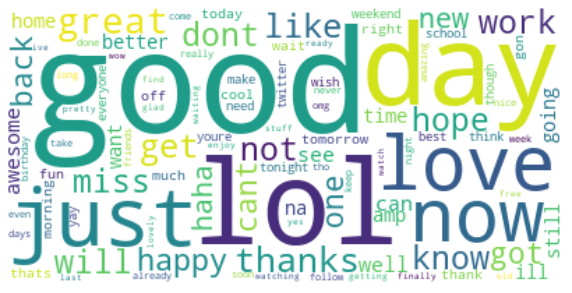

<b>Most used words for reviews marked as neutral</b>

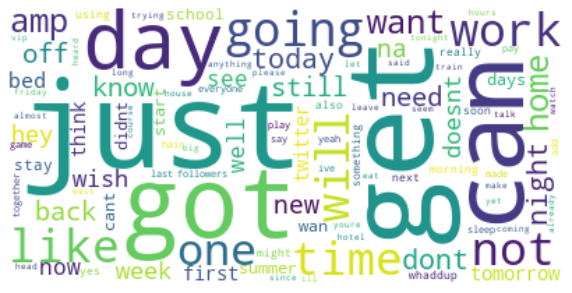

<b>Most used words for reviews marked as negative</b>

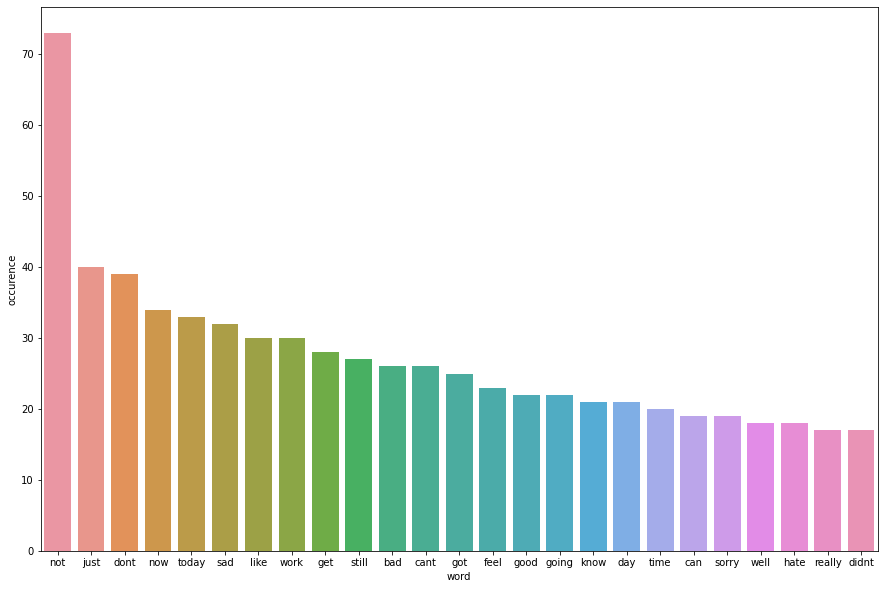

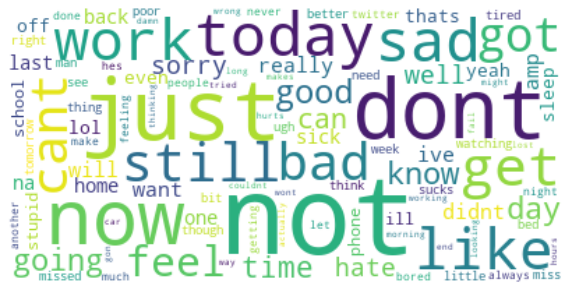

In [125]:
custom_stopwords = [ "a", "about", "above", "after", "again", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", 
             "been", "before", "being", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during",
             "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", 
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into",
             "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "of", "on", "once", "only", "or",
             "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", 
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's",
             "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up",
             "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's",
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've",
             "your", "yours", "yourself", "yourselves" ]

def clean(str):
    str = re.sub("@[A-Za-z0-9_]+","", str) #@nickhandles
    str = re.sub(r'#', '', str) #hastags
    str = re.sub(r'RT[\s]+', '', str) #RT
    str = re.sub(r'[^a-zA-Z ]+', '',str) #all but letters
    return  re.sub(r'\b\w{,2}\b', '', str.lower())

def get_frequencies_with_sentiment(sentiment, type="most"):
    reviews = extract[extract['predominant'] == sentiment]
    sentence = ''
    reviews.tweet = reviews.tweet.apply(lambda x: clean(x))#.apply(lambda x: ' '.join(x))
    reviews.tweet = reviews.tweet.apply(lambda x : ' '.join([word for word in x.split() if word not in (custom_stopwords)]))
#     print(word_tokenize(str(reviews.tweet)))
    
#     print(rewiews.tweet.apply(lambda x: ' '.join(x)))
    for row in reviews.tweet:
        for w in row.split():
#             print(w)
            sentence = sentence + w + ' '
    fd = FreqDist(word.lower() for word in word_tokenize(sentence))
    printmd("Most used words for reviews marked as {}".format(sentiment))
    
    t = fd.most_common()[0:25]
    t = pd.DataFrame(t, columns = ['word', 'occurence'])
    plt.figure(figsize=(15,10))
    sns.barplot(data=t, x='word', y='occurence')
    
    plt.figure(figsize=(10, 10))
    wc = WordCloud(background_color="white", max_words=100)
    # generate word cloud
    wc.generate_from_frequencies(fd)

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    pass;
for sentiment in ['positive', 'neutral', 'negative']:
    get_frequencies_with_sentiment(sentiment)